# SEQUENTIAL DATA MODEL - SP500 EXAMPLE

A central assumption in many modelling tasks is that we are in the presence of independent observations. When this assumption break (or we are just trying different approaches) we need to resort to models that take this structures into account.

This post is not technically intensive and it describes with examples/explanations/intuition some common ways to deal with sequential data.


These examples were done under a library that I wrote for this kind of task and soon Ill write a more _numerical_ article explaining the library in detail along with the theoretical basis (Expectation-Maximization).


The idea is that we observe some data $X=x_0,x_1,x_2,\cdots x_n$ ($x_i \in \mathbb{R}^p$) but the data is not independent (at least we will model it as not independent).

The base object of study is the probability of $X$, $p(X)$, which can be decomposed as

$p(X)=p(x_0)p(x_1|x_0)p(x_2|x_1,x_0) \cdots p(x_n|x_{0:n-1})$







##### Data
To give examples, we will use SP500 Index data from Yahoo Finance.

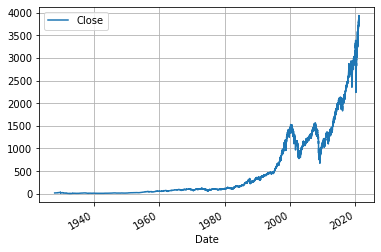

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seqmodels

data=pd.read_csv('SP500.csv')
data.set_index('Date',inplace=True,drop=True)
data=data[['Close']]
data.index=pd.to_datetime(data.index)
data.plot()
plt.grid(True)
plt.show()

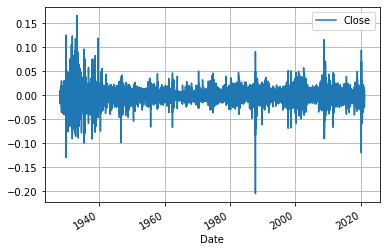

In [2]:
# Build returns px[x(t)]/px[x(t-1)]-1
x=data.pct_change()
x=x.dropna()
x.plot()
plt.grid(True)
plt.show()

## Simple Autoregressive Process

A simple autoregressive process (order 1) is the case where it is assumed that $x_i$ depends on $x_{i-1}$. In this case, the probability of $X$ reduces to:

$p(X)=p(x_0) \Pi_k p(x_k|x_{k-1})$

Trivially, the predictive distribution given that we observed $x_n$ is $p(x_{n+1}|x_n)$.

What is left is to assume some distribution for $(x_k|x_{k-1})$ and find a way to fit the parameters.

Also, from a graphical prespective we can _draw_ the model as:

$x_0 \rightarrow x_1 \rightarrow \cdots$

where the arrows represent depencies.



### Gaussian Distribution

A simple assumption is to assume that $p(x_k|x_{k-1})$ is Gaussian. Another way to look at the problem is to consider that $p(x_k,x_{k-1})$ is jointly Gaussian. If this is the case (there are many distributions where the marginals are Gaussians but they are not jointly Gaussian), and considering the dependencies on the data, one can say that an observation of $\{x_k,x_{k-1}\}$ is and independent observation. As it known, the MLE estimators for the joint Gaussian will be the mean and covariance of $y_k=\{x_k,x_{k-1}\}$.

If $\mu$,$\Sigma$ is the mean vector and covariance matrix of $y$, it is possible to make the following associations for the entries:

$\mu=\{\mu_{x_k},\mu_{x_{k-1}} \}$

$\Sigma=\begin{bmatrix} \Sigma_{x_k} & \Sigma_{x_k,x_{k-1}} \\ \Sigma_{x_{k-1},x_k} & \Sigma_{x_{k-1}} \end{bmatrix}$

Finally, the marginal given an observation $x_{k-1}=q$ is:

$p(x_k|x_{k-1}=q)=N(\mu,\Sigma)$

with $\mu=\mu_{x_k}+\Sigma_{x_k,x_{k-1}} \Sigma_{x_{k-1}}^{-1}(q-\mu_{x_{k-1}})$ and $\Sigma=\Sigma_{x_k}-\Sigma_{x_k,x_{k-1}} \Sigma_{x_{k-1}}^{-1} \Sigma_{x_{k-1},x_k}$.

This is a linear regression (as expected).

Since we modelled the joint, from a graphical prespective we have something like:

$\{x_0,x_1\} \; \{x_1,x_2\} \; \cdots $

as all observations are independent when we model the joint.

As a model for financial fluctuations one can think of this as the possibility of sequential returns to be correlated/anticorrelated. 



In [3]:
# Let us fit this model to X with the seqmodels library
distribution=seqmodels.GaussianDistribution()
gar=seqmodels.AR(lag=1,distribution=distribution)
train=x.values
gar.estimate(train)
gar.view()

** Gaussian Joint Distribution **
Mean
[0.000302 0.000302]
Covariance
[[ 1.44e-04 -2.00e-06]
 [-2.00e-06  1.44e-04]]
Correlation matrix
[[ 1.       -0.013812]
 [-0.013812  1.      ]]
**


Something that can be observed from the parameters is that there is a small tendency for the returns to be negativelly correlated.

Another thing that we can calculate is the probability of the data with the fitted model.

In [4]:
logp=gar.eval_logprob(train)
print('Log P(D|M): ', logp)

Log P(D|M):  70305.80512269482


### Gaussian Mixture Distribution

A similar (but with more representational power) model is to, again, consider the joint $y_k=\{x_k,x_{k-1}\}$ but this time to have a Gaussian Mixture distribution. This is an interesting case as fitting this type of distribution yields a nice introduction to more complex models.

To fit a Gaussian Mixture one can use Expectation-Maximization. 

In [6]:
# Let us fit this model to X with the seqmodels library
distribution=seqmodels.GaussianMixtureDistribution(2)
gmmmar=seqmodels.AR(lag=1,distribution=distribution)
train=x.values
gmmmar.estimate(train)
gmmmar.view()

** Gaussian Mixture Distribution **
Probabilities:  [0.16747299 0.83252701]
** Gaussian Joint Distribution **
Mean
[-0.001526 -0.000665]
Covariance
[[ 6.04e-04 -3.20e-05]
 [-3.20e-05  6.07e-04]]
Correlation matrix
[[ 1.       -0.052981]
 [-0.052981  1.      ]]
**
** Gaussian Joint Distribution **
Mean
[0.00067  0.000496]
Covariance
[[5.e-05 4.e-06]
 [4.e-06 5.e-05]]
Correlation matrix
[[1.       0.072387]
 [0.072387 1.      ]]
**


In [7]:
logp=gmmmar.eval_logprob(train)
print('Log P(D|M): ', logp)

Log P(D|M):  74508.06568061905


From the fitted model we observe two states, one more volatile (with negative expected returns) where returns are negativelly correlated and other less volatile with positive autocorrelation. 

An interesting thing is how to perform a prediction with this model (given that we have a current observation $x_n=q$); the intuition is that the prediction will be Gaussian Mixture as well (where each Gaussian prediction is analogous to the previous case - let's not repeat unecessary equations), but the weights are proportional to how _close_ the current observation is to that emission. In this fitted case, if we have a _large_ flutuation, then it is more probable that the observation came from the Gaussian with largest variance.


Finally, as a graphical model, we can draw the observations as:

$z \rightarrow \{x_k,x_{k-1}\}$


## Hidden Markov Model

In theory we could add more _lags_ to the previous model to try to capture more long term relations; this makes the models harder to estimate and more uncertain. A cool way to increase the dependencies without adding too much complexity is to consider a hidden state (_like_ in the Gaussian Mixture case) but this hidden state is not independent anymore. In graphical terms:

$z_k \rightarrow z_{k+1} \rightarrow \cdots$

$\downarrow  \; \; \; \; \; \; \;  \downarrow$

$x_k \; \; \; \; x_{k+1} \; \; \; \; \; \cdots$


This means that the probability of observation $x_k$ depends on the current state $z_k$ which is unobserved; the state encodes long term relations that may be present in data. As with Gaussian Mixtures we need to resort to Expectation-Maximization to fit the model. Note that, here is being understood the states $z_k$ to be discrete.


When applied to returns this can be interpreted as a switching of emission distribution; in a univariate case, this can be, for example, a positive and negative expected value state - we could expected to model _trends_ in the data with this.




** HMM Parameters **
Initial state distribution
[0.53 0.47]
Transition
[[0.957 0.043]
 [0.011 0.989]]
Emissions
** Gaussian Distribution **
Mean
[-0.000923]
Covariance
[[0.000501]]
Correlation matrix
[[1.]]
**
** Gaussian Distribution **
Mean
[0.000625]
Covariance
[[4.9e-05]]
Correlation matrix
[[1.]]
**



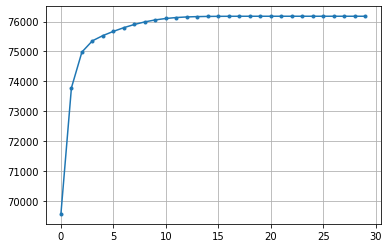

In [9]:
n_states=2
state_distributions=[
                    seqmodels.GaussianDistribution(),
                    seqmodels.GaussianDistribution()
                    ]
hmm=seqmodels.HMM(n_states,state_distributions)
hmm.estimate(train,n_iter=10,n_runs=5,n_refine=20)
hmm.view()
# Check EM convergence to make sure the results make sense
hmm.view_convergence()

In [11]:
logp=hmm.eval_logprob(train)
print('Log P(D|M): ', logp)

Log P(D|M):  76175.24764950435


When modelled with two states, the optimization found parameters that can be interpreted as a negative expected value with high volatility state and another with positive expected value but lower volatility; these states tend to persist (the probability to jump to different state is low).

To predict with a HMM with Gaussian emission we need to compute the current states probability and then transform it with the transition matrix to estimate the next state probabilities; after this, the output distribution will be a Gaussian mixture with mixing weights equal to this probabilities.



### Adding autoregressive terms

There is nothing preventing us to add more _arrows_ in our graphical model. Let us consider for example:

$z_k \rightarrow z_{k+1} \rightarrow \cdots$

$\downarrow  \; \; \; \; \; \; \;  \downarrow$

$x_k \rightarrow x_{k+1} \rightarrow \cdots$


This can mean that there autogression but the state where that autogression comes from changes and may tend to persist (without a complete direct influence of the current observation like in the Gaussian Mixture case). In a univariate returns sequence, this could model, for example, a switching between positive autocorrelation (trend) and negative autocorrelation (reversion). 

Let us give it a try.


** HMM Parameters **
Initial state distribution
[0.165 0.835]
Transition
[[0.989 0.011]
 [0.043 0.957]]
Emissions
** Gaussian Joint Distribution **
Mean
[0.000668 0.000618]
Covariance
[[5.2e-05 5.0e-06]
 [5.0e-06 4.9e-05]]
Correlation matrix
[[1.       0.090321]
 [0.090321 1.      ]]
**
** Gaussian Joint Distribution **
Mean
[-0.001081 -0.000895]
Covariance
[[ 4.86e-04 -2.90e-05]
 [-2.90e-05  5.00e-04]]
Correlation matrix
[[ 1.       -0.058514]
 [-0.058514  1.      ]]
**



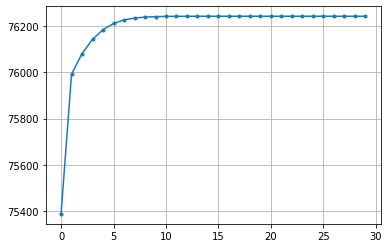

In [12]:
n_states=2
state_distributions=[
                    seqmodels.GaussianDistribution(),
                    seqmodels.GaussianDistribution()
                    ]
arhmm=seqmodels.ARHMM(n_states,state_distributions,lag=1)
arhmm.estimate(train,n_iter=10,n_runs=5,n_refine=20)
arhmm.view()
arhmm.view_convergence()

In [13]:
logp=arhmm.eval_logprob(train)
print('Log P(D|M): ', logp)

Log P(D|M):  76240.94548076953


Similar to the autoregressive with Gaussian mixture, there is a state with low\[high\] volatility with positive\[negative\] expected value and positive\[negative\] correlation.

## Final remarks

In this post we several models for financial fluctuations were tried. Each one of them can model certain effects and which one is closer to the truth is a problem that was not address here.

As a clue for this, let us look at the $p(D|M)$ quantities: The HMM with autoregressive terms has the highest probability - but is also the model with more parameters. In a next post we will address the issues of model selection and how to estimate the expected performance (money of course) of a model when applied to financial time series.  

Thank you!